In [32]:
! pip install --upgrade pip
! pip install PyAthena

In [33]:
from pyathena import connect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [34]:
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [35]:
conn = connect(s3_staging_dir='s3://energy-temperature-data/athena-queries',region_name='us-east-2')

In [68]:
test_2021_df = pd.read_sql("SELECT load_area_id, \
                                    occurance_date_epoch_utc, \
                                    cast(substring(iso_occurance_date_utc, 1,19) as timestamp) iso_occurance_date_utc,\
                                    hrl_load_mw,\
                                    temp,\
                                    temp_feels_like,\
                                    temp_min,\
                                    temp_max,\
                                    humidity,\
                                    cloud_coverage,\
                                    wind_speed,\
                                    wind_direction,\
                                    atmospheric_pressure\
                                FROM lse_demand_planning_stg_catalog.energy_weather_lmp_fact \
                                WHERE occurance_date_epoch_utc >= 1609459200;", conn)

In [70]:
test_2021_df.head()

,load_area_id,occurance_date_epoch_utc,iso_occurance_date_utc,hrl_load_mw,temp,temp_feels_like,temp_min,temp_max,humidity,cloud_coverage,wind_speed,wind_direction,atmospheric_pressure
0,DUQ,1611489600,2021-01-24 12:00:00,1515.108,12.61,4.84,8.06,20.55,85,0.40,3.44,140,1026
1,DUQ,1614672000,2021-03-02 08:00:00,1344.279,22.68,9.90,NaN,24.80,63,0.75,12.66,340,1024
2,DUQ,1611550800,2021-01-25 05:00:00,1404.307,26.20,20.70,24.80,NaN,80,0.90,1.05,321,1016
3,DUQ,1617840000,2021-04-08 00:00:00,1502.855,72.99,70.09,63.37,75.20,38,0.75,3.44,20,1013
4,DUQ,1613138400,2021-02-12 14:00:00,1752.006,22.19,10.80,19.99,24.80,68,0.90,10.36,60,1021


# add additional date and time columns

In [71]:
test_2021_df['hour'] = test_2021_df['iso_occurance_date_utc'].dt.hour

test_2021_df['day'] = test_2021_df['iso_occurance_date_utc'].dt.day

test_2021_df['weekday'] = test_2021_df['iso_occurance_date_utc'].dt.dayofweek

test_2021_df['month'] = test_2021_df['iso_occurance_date_utc'].dt.month

test_2021_df['year'] = test_2021_df['iso_occurance_date_utc'].dt.year

# set index

In [72]:
test_2021_df = test_2021_df.set_index('iso_occurance_date_utc')

In [73]:
test_2021_df = test_2021_df[["load_area_id", \
                                    "occurance_date_epoch_utc", \
                                    "hour", \
                                    "day", \
                                    "weekday", \
                                    "month", \
                                    "year", \
                                    "hrl_load_mw",\
                                    "temp",\
                                    "temp_feels_like",\
                                    "temp_min",\
                                    "temp_max",\
                                    "humidity",\
                                    "cloud_coverage",\
                                    "wind_speed",\
                                    "wind_direction",\
                                    "atmospheric_pressure"]]

In [74]:
test_2021_df.head()

,load_area_id,occurance_date_epoch_utc,hour,day,weekday,month,year,hrl_load_mw,temp,temp_feels_like,temp_min,temp_max,humidity,cloud_coverage,wind_speed,wind_direction,atmospheric_pressure
iso_occurance_date_utc,,,,,,,,,,,,,,,,,
2021-01-24 12:00:00,DUQ,1611489600,12,24,6,1,2021,1515.108,12.61,4.84,8.06,20.55,85,0.40,3.44,140,1026
2021-03-02 08:00:00,DUQ,1614672000,8,2,1,3,2021,1344.279,22.68,9.90,NaN,24.80,63,0.75,12.66,340,1024
2021-01-25 05:00:00,DUQ,1611550800,5,25,0,1,2021,1404.307,26.20,20.70,24.80,NaN,80,0.90,1.05,321,1016
2021-04-08 00:00:00,DUQ,1617840000,0,8,3,4,2021,1502.855,72.99,70.09,63.37,75.20,38,0.75,3.44,20,1013
2021-02-12 14:00:00,DUQ,1613138400,14,12,4,2,2021,1752.006,22.19,10.80,19.99,24.80,68,0.90,10.36,60,1021


# Check for nulls

In [32]:
test_2021_df.isnull().sum()

load_area_id                   0
occurance_date_epoch_utc       0
hour                           0
day                            0
weekday                        0
month                          0
year                           0
hrl_load_mw                   98
temp                         122
temp_feels_like              125
temp_min                    1075
temp_max                    1305
humidity                       0
cloud_coverage                 1
wind_speed                   106
wind_direction                 0
atmospheric_pressure           0
dtype: int64

### Interpolate linearly missing / unreported temperatue values

In [33]:
test_2021_df[test_2021_df['temp'].isnull()]

,load_area_id,occurance_date_epoch_utc,hour,day,weekday,month,year,hrl_load_mw,temp,temp_feels_like,temp_min,temp_max,humidity,cloud_coverage,wind_speed,wind_direction,atmospheric_pressure
iso_occurance_date_utc,,,,,,,,,,,,,,,,,
2021-03-21 16:00:00,DUQ,1616342400,16,21,6,3,2021,1274.449,NaN,46.18,51.71,NaN,26,0.01,6.91,140,1031
2021-03-23 20:00:00,DUQ,1616529600,20,23,1,3,2021,1361.448,NaN,55.17,63.31,NaN,27,0.90,12.66,130,1016
2021-03-25 04:00:00,DUQ,1616644800,4,25,3,3,2021,1134.091,NaN,54.77,53.01,64.40,55,0.40,4.61,250,1013
2021-04-29 08:00:00,DUQ,1619683200,8,29,3,4,2021,1222.174,NaN,64.83,NaN,64.99,88,0.90,4.61,230,1009
2021-02-04 07:00:00,DUQ,1612422000,7,4,3,2,2021,1420.666,NaN,10.58,12.99,21.99,85,0.20,3.44,290,1015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-26 17:00:00,DUQ,1622048400,17,26,2,5,2021,2172.249,NaN,NaN,NaN,NaN,47,0.04,NaN,207,973
2021-05-26 21:00:00,DUQ,1622062800,21,26,2,5,2021,2027.691,NaN,NaN,NaN,NaN,73,0.04,NaN,207,972
2021-02-28 10:00:00,DUQ,1614506400,10,28,6,2,2021,1209.972,NaN,35.06,37.99,43.40,87,0.90,5.75,120,1018


In [75]:
test_2021_df = test_2021_df.interpolate(method ='linear', limit_direction ='forward')

In [85]:
test_2021_df.isnull().sum()

load_area_id                0
occurance_date_epoch_utc    0
hour                        0
day                         0
weekday                     0
month                       0
year                        0
hrl_load_mw                 0
temp                        0
temp_feels_like             0
temp_min                    0
temp_max                    0
humidity                    0
cloud_coverage              0
wind_speed                  0
wind_direction              0
atmospheric_pressure        0
temp_scaled                 0
temp_sqd                    0
dtype: int64

In [56]:
test_2021_df[test_2021_df['temp_max'].isnull()]

,load_area_id,occurance_date_epoch_utc,hour,day,weekday,month,year,hrl_load_mw,temp,temp_feels_like,temp_min,temp_max,humidity,cloud_coverage,wind_speed,wind_direction,atmospheric_pressure
iso_occurance_date_utc,,,,,,,,,,,,,,,,,
2021-01-06 06:00:00,DUQ,1609912800,6,6,2,1,2021,1317.85,32.49,23.07,30.23,NaN,80,0.9,9.17,320,1018


#### temps '2021-03-20 00:00:00' thur '2021-03-30 00:00:00'

<AxesSubplot:xlabel='iso_occurance_date_utc'>

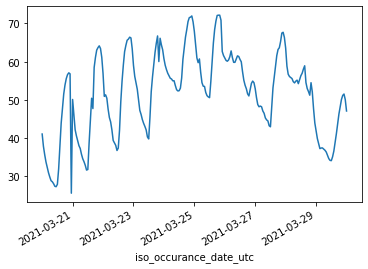

In [36]:
import seaborn as sns
test_2021_df[(test_2021_df.index >= '2021-03-20 00:00:00') & \
                         (test_2021_df.index <= '2021-03-30 00:00:00')]['temp'].plot()

<AxesSubplot:xlabel='iso_occurance_date_utc'>

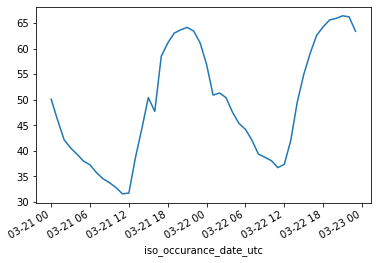

In [38]:
test_2021_df[(test_2021_df.index >= '2021-03-21 00:00:00') & \
                         (test_2021_df.index <= '2021-03-22 23:00:00')]['temp'].plot()

In [90]:
len(test_2021_df.columns)

16

In [91]:
len(train_df.columns)

16

# Training Data

In [55]:
train_df = pd.read_sql("SELECT load_area_id, \
                                    occurance_date_epoch_utc, \
                                    cast(substring(iso_occurance_date_utc, 1,19) as timestamp) iso_occurance_date_utc,\
                                    hrl_load_mw,\
                                    temp,\
                                    temp_feels_like,\
                                    temp_min,\
                                    temp_max,\
                                    humidity,\
                                    cloud_coverage,\
                                    wind_speed,\
                                    wind_direction,\
                                    atmospheric_pressure\
                                FROM lse_demand_planning_stg_catalog.energy_weather_lmp_fact \
                                WHERE occurance_date_epoch_utc < 1609459200;", conn)

In [56]:
train_df.shape

(43848, 13)

# add additional date and time columns

In [57]:
train_df['hour'] = train_df['iso_occurance_date_utc'].dt.hour

train_df['day'] = train_df['iso_occurance_date_utc'].dt.day

train_df['weekday'] = train_df['iso_occurance_date_utc'].dt.dayofweek

train_df['month'] = train_df['iso_occurance_date_utc'].dt.month

train_df['year'] = train_df['iso_occurance_date_utc'].dt.year

# set index

In [58]:
train_df = train_df.set_index('iso_occurance_date_utc')

In [59]:
train_df = train_df[["load_area_id", \
                                    "occurance_date_epoch_utc", \
                                    "hour", \
                                    "day", \
                                    "weekday", \
                                    "month", \
                                    "year", \
                                    "hrl_load_mw",\
                                    "temp",\
                                    "temp_feels_like",\
                                    "temp_min",\
                                    "temp_max",\
                                    "humidity",\
                                    "cloud_coverage",\
                                    "wind_speed",\
                                    "wind_direction",\
                                    "atmospheric_pressure"]]

In [60]:
train_df.head()

,load_area_id,occurance_date_epoch_utc,hour,day,weekday,month,year,hrl_load_mw,temp,temp_feels_like,temp_min,temp_max,humidity,cloud_coverage,wind_speed,wind_direction,atmospheric_pressure
iso_occurance_date_utc,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,DUQ,1451606400,0,1,4,1,2016,1646.344,33.49,24.49,32.96,34.12,71,0.9,8.05,270,1024
2018-09-12 00:00:00,DUQ,1536710400,0,12,2,9,2018,1623.080,64.45,65.44,62.60,66.73,88,0.9,4.61,20,1022
2020-02-25 00:00:00,DUQ,1582588800,0,25,1,2,2020,1532.917,48.78,42.98,47.49,51.08,45,0.9,3.06,279,1012
2017-03-28 08:00:00,DUQ,1490688000,8,28,1,3,2017,1125.410,55.92,53.04,51.80,NaN,77,0.9,4.70,320,1011
2019-03-02 12:00:00,DUQ,1551528000,12,2,5,3,2019,1397.935,30.92,22.82,29.95,NaN,86,0.9,6.91,240,1016


# Check for nulls

In [84]:
train_df.isnull().sum()

load_area_id                0
occurance_date_epoch_utc    0
hour                        0
day                         0
weekday                     0
month                       0
year                        0
hrl_load_mw                 0
temp                        0
temp_feels_like             0
temp_min                    0
temp_max                    0
humidity                    0
cloud_coverage              0
wind_speed                  0
wind_direction              0
atmospheric_pressure        0
temp_scaled                 0
temp_sqd                    0
dtype: int64

### Interpolate linearly missing / unreported temperatue values

In [54]:
train_df.isnull().sum()

load_area_id                    0
occurance_date_epoch_utc        0
hour                            0
day                             0
weekday                         0
month                           0
year                            0
hrl_load_mw                    45
temp                          480
temp_feels_like               447
temp_min                    10412
temp_max                     7676
humidity                        0
cloud_coverage                 13
wind_speed                     71
wind_direction                  0
atmospheric_pressure            0
dtype: int64

In [61]:
train_df[train_df['hrl_load_mw'].isnull()].sort_index

<bound method DataFrame.sort_index of                        load_area_id  occurance_date_epoch_utc  hour  day  \
iso_occurance_date_utc                                                     
2016-09-09 23:00:00             DUQ                1473462000    23    9   
2016-05-29 16:00:00             DUQ                1464537600    16   29   
2019-11-01 13:00:00             DUQ                1572613200    13    1   
2018-11-04 01:00:00             DUQ                1541293200     1    4   
2019-08-12 20:00:00             DUQ                1565640000    20   12   
2017-07-05 14:00:00             DUQ                1499263200    14    5   
2016-11-04 11:00:00             DUQ                1478257200    11    4   
2020-07-29 14:00:00             DUQ                1596031200    14   29   
2018-07-14 22:00:00             DUQ                1531605600    22   14   
2017-09-23 06:00:00             DUQ                1506146400     6   23   
2017-10-05 03:00:00             DUQ               

<AxesSubplot:xlabel='iso_occurance_date_utc'>

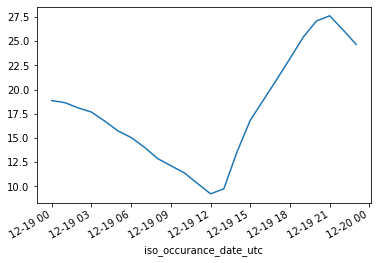

In [60]:
train_df[(train_df.index >= '2019-12-19 00:00:00') & \
                         (train_df.index <= '2019-12-19 23:00:00')]['temp'].plot()

In [62]:
train_df = train_df.interpolate(method ='linear', limit_direction ='forward')

<AxesSubplot:xlabel='iso_occurance_date_utc'>

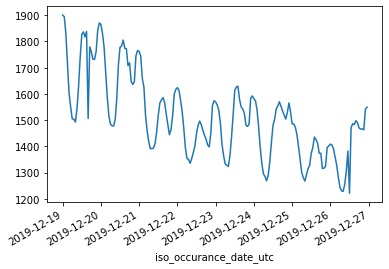

In [64]:
train_df[(train_df.index >= '2019-12-19 00:00:00') & \
                         (train_df.index <= '2019-12-26 23:00:00')]['hrl_load_mw'].plot()

#### Energy (MW) one week

In [63]:
train_df.sort_index(inplace=True)

<AxesSubplot:xlabel='iso_occurance_date_utc'>

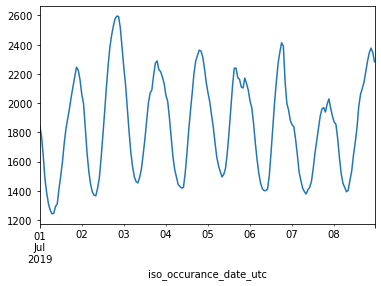

In [76]:
train_df[(train_df.index >= '2019-07-01 00:00:00') & \
                         (train_df.index <= '2019-07-08 23:00:00')]['hrl_load_mw'].plot()

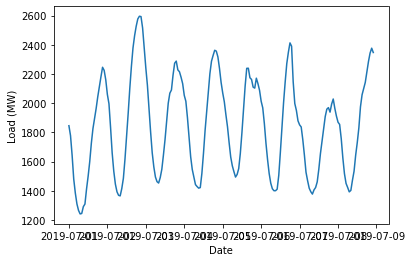

In [86]:
x_index_week = train_df[(train_df.index >= '2019-07-01 00:00:00') & (train_df.index < '2019-07-08 23:00:00')].index
y_mw_week = train_df[(train_df.index >= '2019-07-01 00:00:00') & (train_df.index < '2019-07-08 23:00:00')]['hrl_load_mw']
plt.plot(x_index_week, y_mw_week)
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.show()

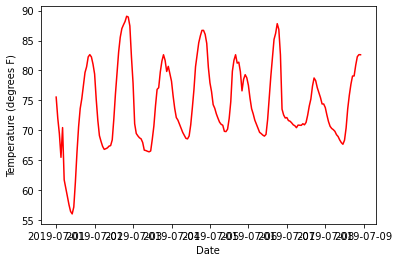

In [89]:
x_index_week =  train_df[(train_df.index >= '2019-07-01 00:00:00') & (train_df.index < '2019-07-08 23:00:00')].index
y_temp_week = train_df[(train_df.index >= '2019-07-01 00:00:00') & (train_df.index < '2019-07-08 23:00:00')]['temp']
plt.plot(x_index_week, y_temp_week, color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (degrees F)')
plt.show()

## Hourly Load MW

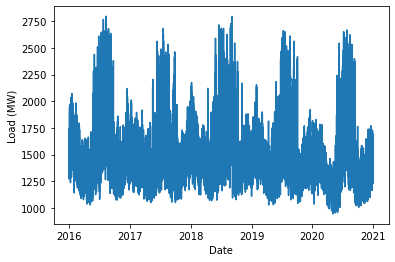

In [78]:
x_index_full = train_df.index
y_mw_full = train_df.hrl_load_mw
plt.plot(x_index_full, y_mw_full)
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.show()

## Temperature

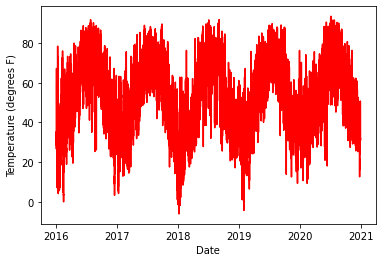

In [80]:
x_index_full = train_df.index
y_temp_full = train_df.temp
plt.plot(x_index_full,y_temp_full, color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (degrees F)')
plt.show()

#### Energy & Temperature  - Full Train

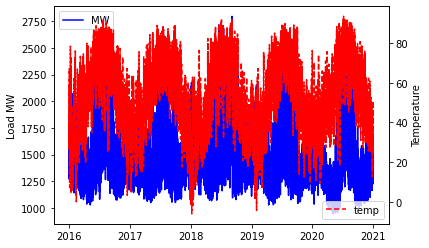

In [81]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(x_index_full, y_mw_full, color='blue', label='MW')
ax_right.plot(x_index_full,y_temp_full, color='red', linestyle='--', label = 'Temperature')
plt.xlabel('DateTime')
ax_left.set_ylabel('Load MW')
ax_right.set_ylabel('Temperature')
ax_left.legend(["MW"], loc ='upper left')
ax_right.legend(["temp"])

plt.show()

#### Energy & Temperature  - one week

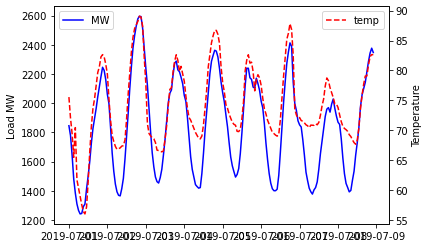

In [90]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(x_index_week, y_mw_week, color='blue', label='MW')
ax_right.plot(x_index_week,y_temp_week, color='red', linestyle='--', label = 'Temperature')
plt.xlabel('DateTime')
ax_left.set_ylabel('Load MW')
ax_right.set_ylabel('Temperature')
ax_left.legend(["MW"], loc ='upper left')
ax_right.legend(["temp"])

plt.show()

# Scatter Plot Temperature vs. Energy

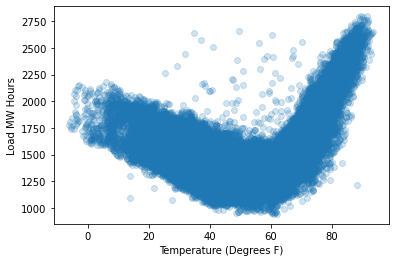

In [92]:
plt.scatter(train_df['temp'], train_df['hrl_load_mw'], alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('Load MW Hours')
plt.show()

#### The relationship between temperature and energy usage appears quadratic in nature

In [93]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

## Standardize Temp

In [64]:
train_df['temp_scaled'] = (train_df['temp']-train_df['temp'].mean())/train_df['temp'].std()

In [80]:
test_2021_df['temp_scaled'] = (test_2021_df['temp']-test_2021_df['temp'].mean())/test_2021_df['temp'].std()

## Quadradic relationship between energy and temp

#### Square scaled temp

In [66]:
train_df['temp_sqd'] = train_df['temp_scaled']**2

In [81]:
test_2021_df['temp_sqd'] = test_2021_df['temp_scaled']**2

## Temperature energy relationship scatter Jan vs. July 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


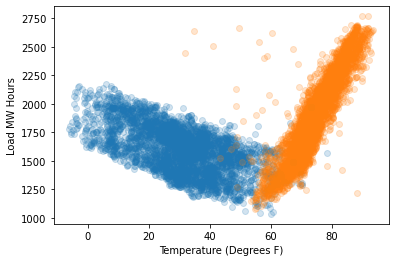

In [99]:
plt.subplot()
plt.scatter(train_df['temp'].where(train_df['month'] == 1), train_df['hrl_load_mw'].where(train_df['month'] == 1), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('Load MW Hours')

plt.subplot()
plt.scatter(train_df['temp'].where(train_df['month'] == 7), train_df['hrl_load_mw'].where(train_df['month'] == 7), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('Load MW Hours')
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


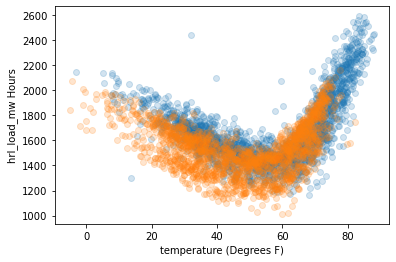

In [100]:
plt.subplot()
plt.scatter(train_df['temp'].where(train_df['hour'] == 0), train_df['hrl_load_mw'].where(train_df['hour'] == 0), alpha = 0.2)
plt.xlabel('temperature (Degrees F)')
plt.ylabel('hrl_load_mw Hours')

plt.subplot()
plt.scatter(train_df['temp'].where(train_df['hour'] == 12), train_df['hrl_load_mw'].where(train_df['hour'] == 12), alpha = 0.2)
plt.xlabel('temperature (Degrees F)')
plt.ylabel('hrl_load_mw Hours')

plt.show()

## Model taking into account:
#### Energy usage dependent on month / season
#### Energy usage dependent on day of week
#### Energy usage dependent on hour of day

#### Model 1 - w/ catagorical variables

In [104]:
mod_one = sm.OLS.from_formula('hrl_load_mw ~ temp_scaled + temp_sqd + C(weekday) + C(hour) + C(month)+ humidity + atmospheric_pressure', data=train_df).fit()
print(mod_one.summary())

                            OLS Regression Results                            
Dep. Variable:            hrl_load_mw   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     5419.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:00:12   Log-Likelihood:            -2.7136e+05
No. Observations:               43848   AIC:                         5.428e+05
Df Residuals:                   43803   BIC:                         5.432e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1252.9828 

## Temperature energy relationship scatter noon vs. midnight

## Include interactions Temp~hour/month & hour~month

In [109]:
mod_two = sm.OLS.from_formula('hrl_load_mw ~ temp_scaled*C(hour) + temp_sqd*C(hour) + temp_scaled*C(month) + temp_sqd*C(month) + C(weekday)*C(hour)+humidity+atmospheric_pressure', data=train_df).fit()
print(mod_two.summary())

                            OLS Regression Results                            
Dep. Variable:            hrl_load_mw   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     1929.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:02:44   Log-Likelihood:            -2.5761e+05
No. Observations:               43848   AIC:                         5.157e+05
Df Residuals:                   43597   BIC:                         5.179e+05
Df Model:                         250                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## In sample Predictions

In [112]:
train_df['fitted_values'] = mod_two.predict()

train_df['APE'] = abs((train_df['hrl_load_mw']-train_df['fitted_values'])/train_df['hrl_load_mw'])*100
print("In sample MAPE: ", train_df['APE'].mean())

In sample MAPE:  3.999624684088472


## Out of Sample Predictions

In [114]:
test_2021_df['predicted_values'] = mod_two.predict(test_2021_df)

test_2021_df['APE'] = abs((test_2021_df['hrl_load_mw']-test_2021_df['predicted_values'])/test_2021_df['hrl_load_mw'])*100
print("Out of sample MAPE: ", test_2021_df['APE'].mean())

Out of sample MAPE:  9.316234037789151


## Out of sample predictions vs Actuals Truth

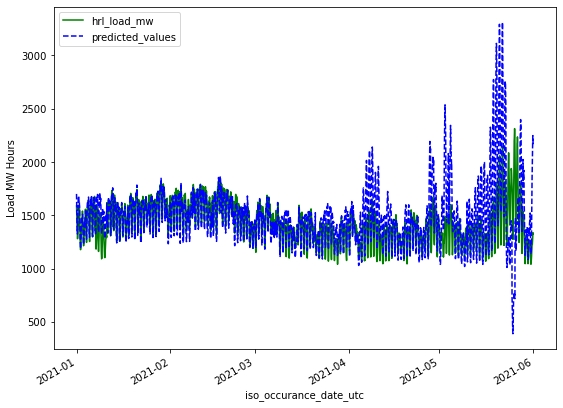

In [117]:
test_2021_df['hrl_load_mw'].plot(color = 'green', figsize=(9,7))

plt.ylabel('Load MW Hours')
plt.xlabel('Date')

test_2021_df['predicted_values'].plot(color = 'blue', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

## Prepare data for AWS AutoML (AutoPilot)

## Train

In [67]:
len(train_df.columns)

19

In [44]:
train_df.columns

Index(['load_area_id', 'occurance_date_epoch_utc', 'hour', 'day', 'weekday',
       'month', 'year', 'hrl_load_mw', 'temp', 'temp_feels_like', 'temp_min',
       'temp_max', 'humidity', 'cloud_coverage', 'wind_speed',
       'wind_direction', 'atmospheric_pressure'],
      dtype='object')

## Add dummies

In [45]:
train_df= pd.get_dummies(train_df, columns=['hour'], prefix="dmy", prefix_sep="_hr")

In [46]:
train_df= pd.get_dummies(train_df, columns=['weekday'], prefix="dmy", prefix_sep="_wkd")

In [47]:
train_df= pd.get_dummies(train_df, columns=['month'], prefix="dmy", prefix_sep="_mnth")

In [48]:
train_df.columns

Index(['load_area_id', 'occurance_date_epoch_utc', 'day', 'year',
       'hrl_load_mw', 'temp', 'temp_feels_like', 'temp_min', 'temp_max',
       'humidity', 'cloud_coverage', 'wind_speed', 'wind_direction',
       'atmospheric_pressure', 'dmy_hr0', 'dmy_hr1', 'dmy_hr2', 'dmy_hr3',
       'dmy_hr4', 'dmy_hr5', 'dmy_hr6', 'dmy_hr7', 'dmy_hr8', 'dmy_hr9',
       'dmy_hr10', 'dmy_hr11', 'dmy_hr12', 'dmy_hr13', 'dmy_hr14', 'dmy_hr15',
       'dmy_hr16', 'dmy_hr17', 'dmy_hr18', 'dmy_hr19', 'dmy_hr20', 'dmy_hr21',
       'dmy_hr22', 'dmy_hr23', 'dmy_wkd0', 'dmy_wkd1', 'dmy_wkd2', 'dmy_wkd3',
       'dmy_wkd4', 'dmy_wkd5', 'dmy_wkd6', 'dmy_mnth1', 'dmy_mnth2',
       'dmy_mnth3', 'dmy_mnth4', 'dmy_mnth5', 'dmy_mnth6', 'dmy_mnth7',
       'dmy_mnth8', 'dmy_mnth9', 'dmy_mnth10', 'dmy_mnth11', 'dmy_mnth12'],
      dtype='object')

In [89]:
del train_df['temp_feels_like']
del train_df['temp_min']
del train_df['temp_max']
# del train_df['fitted_values']
# del train_df['APE']

In [50]:
a = train_df.columns[train_df.columns.str.startswith('temp_')]
b = train_df.columns[train_df.columns.str.startswith('dmy_mnth')]
c = train_df.columns[train_df.columns.str.startswith('dmy_hr')]
d = train_df.columns[train_df.columns.str.startswith('dmy_wkd')]

for col1 in a:
    for col2 in b:
         train_df[col2 + '_' + col1.split('_')[1]] = train_df[col1].mul(train_df[col2])

for col1 in a:
    for col2 in c:
         train_df[col2 + '_' + col1.split('_')[1]] = train_df[col1].mul(train_df[col2])

for col1 in d:
    for col2 in c:
        train_df[col2 + '_' + col1.split('_')[1]] = train_df[col1].mul(train_df[col2])



In [51]:
train_df.columns

Index(['load_area_id', 'occurance_date_epoch_utc', 'day', 'year',
       'hrl_load_mw', 'temp', 'humidity', 'cloud_coverage', 'wind_speed',
       'wind_direction',
       ...
       'dmy_hr14_wkd6', 'dmy_hr15_wkd6', 'dmy_hr16_wkd6', 'dmy_hr17_wkd6',
       'dmy_hr18_wkd6', 'dmy_hr19_wkd6', 'dmy_hr20_wkd6', 'dmy_hr21_wkd6',
       'dmy_hr22_wkd6', 'dmy_hr23_wkd6'],
      dtype='object', length=222)

In [140]:
# train_df[["dmy_hr14", "dmy_wkd6", 'dmy_hr14_wkd6']].where(train_df['dmy_hr14'] == 1 & train_df['dmy_wkd6']==1)

temp = train_df[(train_df['dmy_hr14'] == 1) & (train_df['dmy_wkd6'] == 1)] 


In [142]:
temp[["dmy_hr14", "dmy_wkd6", 'dmy_hr14_wkd6']].head()

,dmy_hr14,dmy_wkd6,dmy_hr14_wkd6
iso_occurance_date_utc,,,
2016-01-03 14:00:00,1,1,1
2016-01-10 14:00:00,1,1,1
2016-01-17 14:00:00,1,1,1
2016-01-24 14:00:00,1,1,1
2016-01-31 14:00:00,1,1,1


In [52]:
len(train_df.columns)

222

## Test

In [143]:
test_2021_df.columns

Index(['load_area_id', 'occurance_date_epoch_utc', 'hour', 'day', 'weekday',
       'month', 'year', 'hrl_load_mw', 'temp', 'temp_feels_like', 'temp_min',
       'temp_max', 'humidity', 'cloud_coverage', 'wind_speed',
       'wind_direction', 'atmospheric_pressure', 'temp_scaled', 'temp_sqd',
       'predicted_values', 'APE'],
      dtype='object')

In [88]:
del test_2021_df['temp_feels_like']
del test_2021_df['temp_min']
del test_2021_df['temp_max']
# del test_2021_df['predicted_values']
# del test_2021_df['APE']

In [147]:
test_2021_df= pd.get_dummies(test_2021_df, columns=['hour'], prefix="dmy", prefix_sep="_hr")

In [148]:
test_2021_df= pd.get_dummies(test_2021_df, columns=['weekday'], prefix="dmy", prefix_sep="_wkd")

In [149]:
test_2021_df= pd.get_dummies(test_2021_df, columns=['month'], prefix="dmy", prefix_sep="_mnth")

In [150]:
a = test_2021_df.columns[test_2021_df.columns.str.startswith('temp_')]
b = test_2021_df.columns[test_2021_df.columns.str.startswith('dmy_mnth')]
c = test_2021_df.columns[test_2021_df.columns.str.startswith('dmy_hr')]
d = test_2021_df.columns[test_2021_df.columns.str.startswith('dmy_wkd')]

for col1 in a:
    for col2 in b:
         test_2021_df[col2 + '_' + col1.split('_')[1]] = test_2021_df[col1].mul(test_2021_df[col2])

for col1 in a:
    for col2 in c:
         test_2021_df[col2 + '_' + col1.split('_')[1]] = test_2021_df[col1].mul(test_2021_df[col2])

for col1 in d:
    for col2 in c:
        test_2021_df[col2 + '_' + col1.split('_')[1]] = test_2021_df[col1].mul(test_2021_df[col2])


In [153]:
test_2021_df.columns

Index(['load_area_id', 'occurance_date_epoch_utc', 'day', 'year',
       'hrl_load_mw', 'temp', 'humidity', 'cloud_coverage', 'wind_speed',
       'wind_direction',
       ...
       'dmy_hr14_wkd6', 'dmy_hr15_wkd6', 'dmy_hr16_wkd6', 'dmy_hr17_wkd6',
       'dmy_hr18_wkd6', 'dmy_hr19_wkd6', 'dmy_hr20_wkd6', 'dmy_hr21_wkd6',
       'dmy_hr22_wkd6', 'dmy_hr23_wkd6'],
      dtype='object', length=275)

In [154]:
temp = test_2021_df[(test_2021_df['dmy_hr14'] == 1) & (test_2021_df['dmy_wkd6'] == 1)]
temp[["dmy_hr14", "dmy_wkd6", 'dmy_hr14_wkd6']].head()

,dmy_hr14,dmy_wkd6,dmy_hr14_wkd6
iso_occurance_date_utc,,,
2021-01-03 14:00:00,1,1,1
2021-01-10 14:00:00,1,1,1
2021-01-17 14:00:00,1,1,1
2021-05-16 14:00:00,1,1,1
2021-05-23 14:00:00,1,1,1


## write dataframe to S3 in csv format

#### Train

In [92]:
from io import StringIO
import boto3

bucket = 'energy-temperature-data' # already created on S3
csv_buffer = StringIO()
train_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'energy_weather_automl/train.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '7WQVPS1K5CQT8E7X',
  'HostId': '0cOM7yhN+NUm3U9flgtXM5qak6U+IB7YZj2gBJKqRv6YWdytfFu2PnLmTzJ8EhSu7HCFKgvQczA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '0cOM7yhN+NUm3U9flgtXM5qak6U+IB7YZj2gBJKqRv6YWdytfFu2PnLmTzJ8EhSu7HCFKgvQczA=',
   'x-amz-request-id': '7WQVPS1K5CQT8E7X',
   'date': 'Sat, 05 Jun 2021 22:30:38 GMT',
   'etag': '"57320537b261108431739306fd06445c"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"57320537b261108431739306fd06445c"'}

#### Test

In [93]:
from io import StringIO
import boto3

bucket = 'energy-temperature-data'
csv_buffer = StringIO()
test_2021_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'energy_weather_automl/test.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'Q3K3X05DVEK106TC',
  'HostId': 'FcGQ57ze6SaDL3xcQvOAv7BZ6TZ9UDYKX+vovzPj7fwkS7W2YKGtAUQgbl4vKZ23FSmJ0stBIB8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'FcGQ57ze6SaDL3xcQvOAv7BZ6TZ9UDYKX+vovzPj7fwkS7W2YKGtAUQgbl4vKZ23FSmJ0stBIB8=',
   'x-amz-request-id': 'Q3K3X05DVEK106TC',
   'date': 'Sat, 05 Jun 2021 22:30:55 GMT',
   'etag': '"309755327348b8d77abbbb6769b9f7a2"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"309755327348b8d77abbbb6769b9f7a2"'}

## AWS AutoMl AutoPilot Model created - Test Accuracy of "best model" 

In [2]:
import boto3
import pandas as pd

#### import test csv - drop hrl_load_mw (remove lable)

In [3]:
bucket = "energy-temperature-data"
file_name = "energy_weather_automl/test.csv"
s3 = boto3.client('s3') 
obj = s3.get_object(Bucket= bucket, Key= file_name) 

test_df = pd.read_csv(obj['Body']) 
test_df.head()

,iso_occurance_date_utc,load_area_id,occurance_date_epoch_utc,hour,day,weekday,month,year,hrl_load_mw,temp,humidity,cloud_coverage,wind_speed,wind_direction,atmospheric_pressure,temp_scaled,temp_sqd
0,2021-01-24 12:00:00,DUQ,1611489600,12,24,6,1,2021,1515.108,12.61,85,0.40,3.44,140,1026,-1.914504,3.665325
1,2021-03-02 08:00:00,DUQ,1614672000,8,2,1,3,2021,1344.279,22.68,63,0.75,12.66,340,1024,-1.257825,1.582125
2,2021-01-25 05:00:00,DUQ,1611550800,5,25,0,1,2021,1404.307,26.20,80,0.90,1.05,321,1016,-1.028281,1.057363
3,2021-04-08 00:00:00,DUQ,1617840000,0,8,3,4,2021,1502.855,72.99,38,0.75,3.44,20,1013,2.022959,4.092362
4,2021-02-12 14:00:00,DUQ,1613138400,14,12,4,2,2021,1752.006,22.19,68,0.90,10.36,60,1021,-1.289779,1.663530


In [4]:
del test_df['hrl_load_mw']

In [5]:
test_df.head()

,iso_occurance_date_utc,load_area_id,occurance_date_epoch_utc,hour,day,weekday,month,year,temp,humidity,cloud_coverage,wind_speed,wind_direction,atmospheric_pressure,temp_scaled,temp_sqd
0,2021-01-24 12:00:00,DUQ,1611489600,12,24,6,1,2021,12.61,85,0.40,3.44,140,1026,-1.914504,3.665325
1,2021-03-02 08:00:00,DUQ,1614672000,8,2,1,3,2021,22.68,63,0.75,12.66,340,1024,-1.257825,1.582125
2,2021-01-25 05:00:00,DUQ,1611550800,5,25,0,1,2021,26.20,80,0.90,1.05,321,1016,-1.028281,1.057363
3,2021-04-08 00:00:00,DUQ,1617840000,0,8,3,4,2021,72.99,38,0.75,3.44,20,1013,2.022959,4.092362
4,2021-02-12 14:00:00,DUQ,1613138400,14,12,4,2,2021,22.19,68,0.90,10.36,60,1021,-1.289779,1.663530


#### write file w/o label

In [6]:
from io import StringIO
import boto3

bucket = 'energy-temperature-data'
csv_buffer = StringIO()
test_df.to_csv(csv_buffer, index=False)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'energy_weather_automl/test_rmlabel.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'CDBT6XFJ0JS0B0A0',
  'HostId': 'T6q/dONtRBAZWWHfg6NuD2PHxsRJ1TaPlO2si/sNgzSPEuZJ6/5sLiJ9HLzeOFyQ7CF8vBWuuc4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'T6q/dONtRBAZWWHfg6NuD2PHxsRJ1TaPlO2si/sNgzSPEuZJ6/5sLiJ9HLzeOFyQ7CF8vBWuuc4=',
   'x-amz-request-id': 'CDBT6XFJ0JS0B0A0',
   'date': 'Sun, 06 Jun 2021 16:41:02 GMT',
   'etag': '"7e2a7685bfd94709863680c497415174"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"7e2a7685bfd94709863680c497415174"'}

## Invoke model endpoint with test features

In [7]:
import sys
import csv
import boto3
bucket = "energy-temperature-data"
file_name = "energy_weather_automl/test_rmlabel.csv"

end_point_name = 'lse-demand-planning-trial2-f5024f2b2f254b7eb655ec496a4aa35e'
sm_rt = boto3.Session().client('runtime.sagemaker')

s3 = boto3.client('s3') 
data = s3.get_object(Bucket= bucket, Key= file_name) 

lines = data['Body'].read().decode('utf-8').splitlines(True)
reader = csv.reader(lines)

cntr = 0
for row in reader:    
    if cntr == 0:
        cntr+=1
        continue
    else:
        index = row[0]
        row = str(row)[1:-1]
        response = sm_rt.invoke_endpoint(EndpointName=end_point_name, 
                                         ContentType='text/csv',       
                                         Accept='text/csv', Body=row)
        
        response = response['Body'].read().decode("utf-8")
        test_df.loc[index,['predicted_values']] = response       
        

## Demo Invoke Endpoint

In [9]:
import sys
import csv
import boto3
bucket = "energy-temperature-data"
file_name = "energy_weather_automl/test_rmlabel.csv"

end_point_name = 'lse-demand-planning-trial2-f5024f2b2f254b7eb655ec496a4aa35e'
sm_rt = boto3.Session().client('runtime.sagemaker')

s3 = boto3.client('s3') 
data = s3.get_object(Bucket= bucket, Key= file_name) 

lines = data['Body'].read().decode('utf-8').splitlines(True)
reader = csv.reader(lines)

cntr = 0
for row in reader:    
    if cntr == 0:
        cntr+=1
        continue
    elif cntr >= 5:
        break
    else:
        print(row[0])
        row = str(row)[1:-1]
        response = sm_rt.invoke_endpoint(EndpointName=end_point_name, 
                                         ContentType='text/csv',       
                                         Accept='text/csv', Body=row)
        
        response = response['Body'].read().decode("utf-8")
        print(str(response))
    cntr+=1

2021-01-24 12:00:00
1679.4661865234375
2021-03-02 08:00:00
1617.9146728515625
2021-01-25 05:00:00
1622.079833984375
2021-04-08 00:00:00
1739.96435546875


In [108]:
test_df = test_df.set_index('iso_occurance_date_utc')

In [110]:
test_df['predicted_values'] = 1.00

## Out of Sample AutoMl model MAPE

In [130]:
test_df['predicted_values']=test_df['predicted_values'].astype(float)

In [132]:
test_df['APE'] = abs((test_df['hrl_load_mw']-test_df['predicted_values'])/test_df['hrl_load_mw'])*100
print("Out of sample AutoML MAPE: ", test_df['APE'].mean())

Out of sample AutoML MAPE:  21.22777661821416
